# Setup

In [1]:
#import libraries
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
#import cv2 as cv

from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn import svm
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble  import HistGradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [2]:
feature_data_folder = './feature_data/'

In [3]:
#load all features & labels
#hog features
train_hog = np.load(feature_data_folder + 'hog/train_hog.npy')
#test_hog = np.load(feature_data_folder + 'hog/test_hog.npy')
val_hog = np.load(feature_data_folder + 'hog/val_hog.npy')

#resnet feature maps
train_resnet = np.load(feature_data_folder + 'resnet18/train-fmaps.npy')
#test_resnet = np.load(feature_data_folder + 'resnet18/test-fmaps.npy')
val_resnet = np.load(feature_data_folder + 'resnet18/val-fmaps.npy')

#sift features
train_sift = np.load(feature_data_folder + 'sift/train_sift.npy')
#test_sift = np.load(feature_data_folder + 'sift/test_sift.npy')
val_sift = np.load(feature_data_folder + 'sift/val_sift.npy')

#glcm
train_glcm = np.load(feature_data_folder + 'glcm/train_glcm.npy')
val_glcm = np.load(feature_data_folder + 'glcm/val_glcm.npy')
test_glcm = np.load(feature_data_folder + 'glcm/val_glcm.npy')

#load labels
train_labels = np.load(feature_data_folder + 'resnet18/train-labels.npy')
test_labels = np.load(feature_data_folder + 'resnet18/test-labels.npy')
val_labels = np.load(feature_data_folder + 'resnet18/val-labels.npy')

In [4]:
print(train_hog.shape)
print(train_resnet.shape)
print(train_sift.shape)
print(train_glcm.shape)
print(train_labels.shape)

(8252, 1000)
(8252, 512)
(8252, 1500)
(8252, 5)
(8252,)


In [5]:
resnet_scaler = StandardScaler().fit(train_resnet)
hog_scaler = StandardScaler().fit(train_hog)
sift_scaler = StandardScaler().fit(train_sift)
glcm_scaler = StandardScaler().fit(train_glcm)

train_resnet = resnet_scaler.transform(train_resnet)
train_hog = hog_scaler.transform(train_hog)
train_sift = sift_scaler.transform(train_sift)
train_glcm = glcm_scaler.transform(train_glcm)

val_resnet = resnet_scaler.transform(val_resnet)
val_hog = hog_scaler.transform(val_hog)
val_sift = sift_scaler.transform(val_sift)
val_glcm = glcm_scaler.transform(val_glcm)

In [6]:
#concat all features into 1d vector
train_features = np.concatenate((train_hog, train_resnet, train_sift, train_glcm), axis = 1)
#test_features = np.concatenate((test_hog, test_resnet, test_sift), axis = 1)
val_features = np.concatenate((val_hog, val_resnet, val_sift, val_glcm), axis = 1)

In [7]:
#2 feature testing
train_features_2 = np.concatenate((train_resnet, train_sift), axis = 1)
#test_features_2 = np.concatenate((test_resnet, test_sift), axis = 1)
val_features_2 = np.concatenate((val_resnet, val_sift), axis = 1)

# Majority Baseline

In [8]:
#using np.ones b/c 1 is majority class
train_majority_label = np.ones(train_labels.shape)
accuracy_score(train_labels, train_majority_label)

0.38681531749878817

In [9]:
val_majority_label = np.ones(val_labels.shape)
accuracy_score(val_labels, val_majority_label)

0.4334053275737941

# Baseline LR

In [10]:
clf = LogisticRegression(n_jobs = 2).fit(train_features, train_labels)

In [11]:
clf.score(train_features, train_labels)

1.0

In [12]:
clf.score(val_features, val_labels)

0.6814254859611231

In [13]:
preds = clf.predict(train_features)
corr = preds == train_labels

In [14]:
df = pd.DataFrame({'correct': corr, 'label': train_labels})

Text(0, 0.5, 'Count')

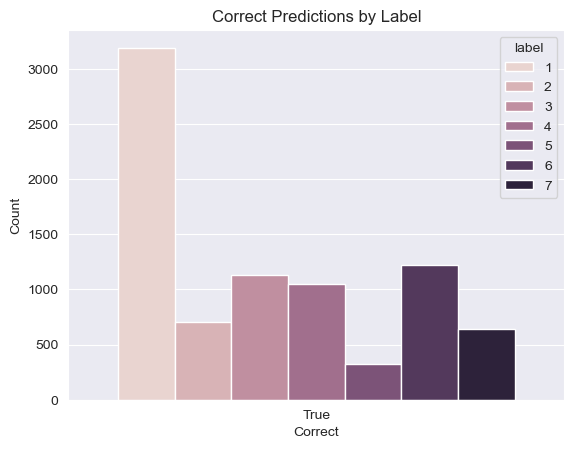

In [15]:
ax = sns.countplot(df, x='correct', hue='label')
ax.set_title('Correct Predictions by Label')
ax.set_xlabel('Correct')
ax.set_ylabel('Count')

## Class Rebalancing

In [16]:
unique, counts = np.unique(train_labels, return_counts = True)
print(unique, counts) #min count is 343
min_label = min(counts)
print(min_label)

[1 2 3 4 5 6 7] [3192  706 1127 1050  322 1218  637]
322


In [17]:
balanced_ids = []
for label in np.unique(train_labels):
    balanced_ids.append(np.where(train_labels == label)[0][:min_label])
balanced_ids = np.array(balanced_ids).flatten()
balanced_train_labels = train_labels[balanced_ids]
balanced_train_features = train_features[balanced_ids]

In [18]:
print(balanced_train_labels.shape)
print(balanced_train_features.shape)

(2254,)
(2254, 3017)


# SVM

In [19]:
# clf = HistGradientBoostingClassifier(
#     max_iter=25,
#     learning_rate=0.1,
#     max_depth=8,
#     class_weight='balanced').fit(train_features, train_labels)

In [23]:
clf = svm.SVC(class_weight = 'balanced').fit(train_features, train_labels)

In [24]:
def validation_score(estimator, X, y):
    y_pred = estimator.predict(val_features)
    return accuracy_score(val_labels, y_pred)

In [ ]:
#param_grid={'C': [0.1,1,10,100] }
param_grid={'C': [10,12.5,15] }
clf = GridSearchCV(clf, param_grid, scoring=validation_score).fit(train_features, train_labels)

In [60]:
clf.best_estimator_

SVC(C=10, class_weight='balanced')

In [61]:
sorted(clf.cv_results_.keys())

['mean_fit_time',
 'mean_score_time',
 'mean_test_score',
 'param_C',
 'params',
 'rank_test_score',
 'split0_test_score',
 'split1_test_score',
 'split2_test_score',
 'split3_test_score',
 'split4_test_score',
 'std_fit_time',
 'std_score_time',
 'std_test_score']

In [10]:
clf.score(train_hog, train_labels)

0.9280133928571429

In [11]:
clf.score(val_hog, val_labels)

0.5687203791469194

In [12]:
cm_train = confusion_matrix(train_labels, clf.predict(train_hog))
cm_val = confusion_matrix(val_labels, clf.predict(val_hog))

In [45]:
ConfusionMatrixDisplay(cm_train).plot()

NameError: name 'cm_train' is not defined

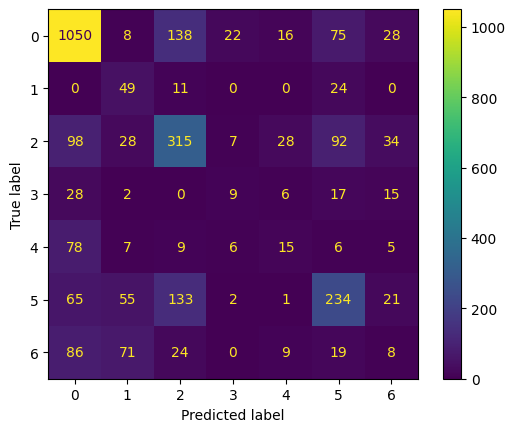

In [16]:
ConfusionMatrixDisplay(cm_val).plot()

Text(0, 0.5, 'Count')

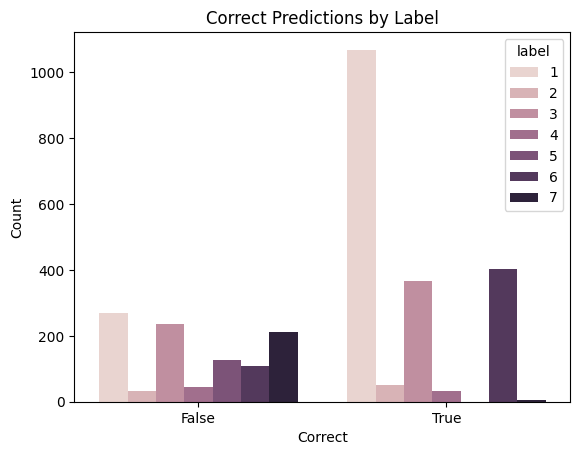

In [98]:
preds = clf.predict(val_features)
corr = preds == val_labels
df = pd.DataFrame({'correct': corr, 'label': val_labels})
ax = sns.countplot(df, x='correct', hue='label')
ax.set_title('Correct Predictions by Label')
ax.set_xlabel('Correct')
ax.set_ylabel('Count')

In [27]:
svc_clf = svm.SVC(class_weight = 'balanced').fit(balanced_train_features, balanced_train_labels)

In [28]:
svc_clf.score(balanced_train_features, balanced_train_labels)

0.9995563442768411

In [29]:
svc_clf.score(val_features, val_labels)

0.5071994240460763

Text(0, 0.5, 'Count')

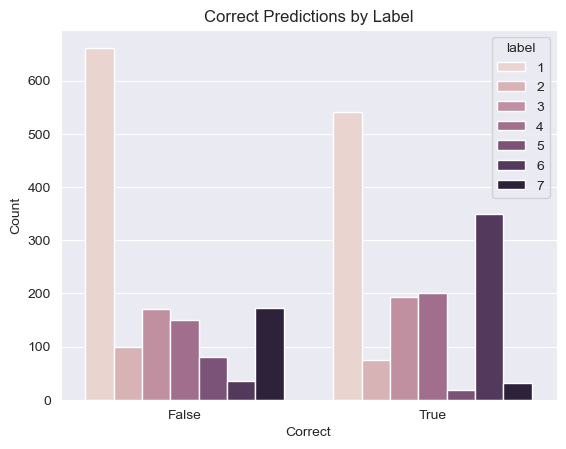

In [30]:
preds = svc_clf.predict(val_features)
corr = preds == val_labels
df = pd.DataFrame({'correct': corr, 'label': val_labels})
ax = sns.countplot(df, x='correct', hue='label')
ax.set_title('Correct Predictions by Label')
ax.set_xlabel('Correct')
ax.set_ylabel('Count')

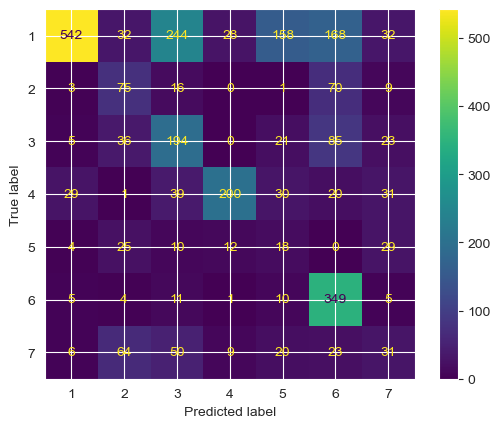

In [31]:
#confusion matrix
cm = confusion_matrix(val_labels, preds, labels = svc_clf.classes_)
disp = ConfusionMatrixDisplay(cm, display_labels = svc_clf.classes_)
disp.plot()
plt.show()

# Linear SVM

In [32]:
linear_svc = svm.LinearSVC().fit(train_features, train_labels)

C:\Users\linni\anaconda3\envs\comp_vision\lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [33]:
linear_svc.score(train_features, train_labels)

1.0

In [34]:
linear_svc.score(val_features, val_labels)

0.6220302375809935

# PCA

In [35]:
pca = PCA()
pca.fit(train_features)

PCA()

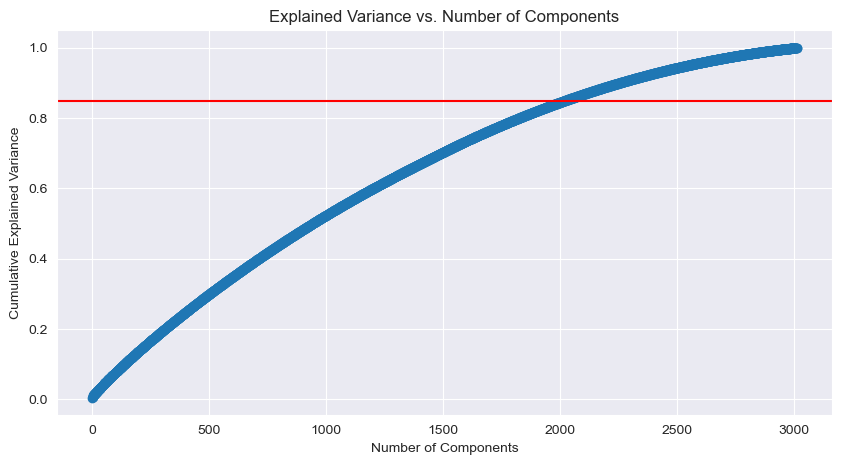

In [36]:
explained_variance = np.cumsum(pca.explained_variance_ratio_)

plt.figure(figsize=(10, 5))
plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker='o', linestyle='--')
# draw a line at 90% of explained variance
plt.axhline(y=0.85, color='r', linestyle='-')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance vs. Number of Components')
plt.grid(True)
plt.show()

In [37]:
pca = PCA(n_components=1250)
pca.fit(train_features)

PCA(n_components=1250)

In [38]:
train_features_pca = pca.transform(train_features)
val_features_pca = pca.transform(val_features)
#test_features_pca = pca.transform(test_features)

In [39]:
svc_clf = svm.SVC(class_weight = 'balanced').fit(train_features_pca, train_labels)

In [40]:
svc_clf.score(train_features_pca, train_labels)

0.9739457101308774

In [41]:
svc_clf.score(val_features_pca, val_labels)

0.603671706263499